# Samplings in GMM

본 코드는 Gaussian Mixture Model에서 Forward Sampling과 Rejection Sampling의 구현 예시입니다.  
본 코드를 통하여, 기초적인 Sampling Based Inference인 Forward Sampling과 Rejection Sampling의 이론과 구현 과정을 익힐 수 있습니다.


### Forward Sampling
Forward Sampling은 Bayesian network의 위상적 순서에 따라 Sample을 반복적으로 생성하는 간단하고 직관적인 방법입니다.  
Gaussian Mixture Model의 Hyper parameter에는 다항 분포의 π와 Gaussian distribution의 μ,Σ가 있습니다.  
또한 GMM의 확률 변수의 위상적 순서는 z 다음 X이므로, Forward Sampling 구현 순서는 다음과 같습니다.  

1. Hyperparameter π로부터 z를 sampling
   이때, z는 Mixture distribution의 indicator 역할을 수행한다. 
2. 생성된 sample z를 이용하여, $N(\mu_{z},\Sigma_{z})$로부터 X를 sampling
3. 1.- 2.를 전체 sample 갯수만큼 반복 실행


### Rejection Sampling
Rejection Sampling은 Sampling을 진행하면서 구하려 하는 확률의 조건을 만족하는 Sample은 accpet하고, 만족하지 않는 Sample은 reject하는 방법입니다.  
앞선 Forward Sampling과 유사하게 Sampling을 반복적으로 생성하지만, Sampling을 하면서 확률의 조건에 맞지 않는 Sample은 reject한다는 점에서 차이가 있습니다.    

실제 구현에서는  순서는 아래와 같습니다. 

1. {1,2,3}에서 random하게 z를 sampling  
2. 생성된 sample z를 이용하여, $N(\mu_{z},\Sigma_{z})$로부터 X를 sampling  
   이때, q(x) = GMM with $q_{1}= N(\mu_{q_{1}},\Sigma_{q_{1}})$,$q_{2}= N(\mu_{q_{2}},\Sigma_{q_{2}})$,$q_{3}= N(\mu_{q_{3}},\Sigma_{q_{3}})$
3. Uniform(0,1)로부터 u를 sampling
4. if M*u*q(x) < p(x);
    Accept the sample & 값을 저장
   else;
    Reject the sample & 값을 기록
5. 1)-4)를 전체 sample 갯수만큼 반복 실행

In [27]:
'''
@ copyright: AAI lab (http://aailab.kaist.ac.kr/xe2/page_GBex27)
@ author: Moon Il-chul: icmoon@kaist.ac.kr
@ annotated by Shin Dong-Hyeok: tlsehdgur0@kaist.ac.kr
'''

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm

%matplotlib inline  

## Forward Sampling

In [28]:
# GMM Hyper paramter의 true value 부여
pi_true = np.array([0.35, 0.45, 0.2]) # Hyperparameter π의 실제 값
mu_true = np.array([-2,1,5]) # Hyperparameter μ의 실제 값
sigma_true = np.array([0.9, 0.3, 0.7]) # Hyperparameter Σ의 실제 값

N = 10000 # N : 전체 샘플의 갯수
obs = np.zeros(N) # obs : N개의 샘플, X의 값을 저장  

for i in range(N): # 전체 샘플의 갯수만큼 반복
    # z에 대한 샘플링 과정
    z = np.random.random_sample() # [0.0, 1.0)에서 임의의 실수를 선택 
    idx = 0
    tempSum = 0
    # z가 속한 범위에 따라 Hyperparameter의 index를 결정하는 과정
    # ex) [0,0.35) -> 0 , [0.35,0.8) -> 1, [0.8,1) -> 2
    for j in range(np.size(pi_true)):
        if ((z >= tempSum) & (z<tempSum+pi_true[j])):
            idx = j
            break
        else:
            tempSum = tempSum + pi_true[j]
    
    # X에 대한 샘플링 과정
    # 샘플링한 z의 값에 대응하는 μ,Σ를 갖는 다변수 가우스 분포에서 X를 샘플링
    v_temp = np.random.normal(mu_true[idx], sigma_true[idx], 1)
    obs[i] = v_temp;
    

C:\Users\Dong-Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
C:\Users\Dong-Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


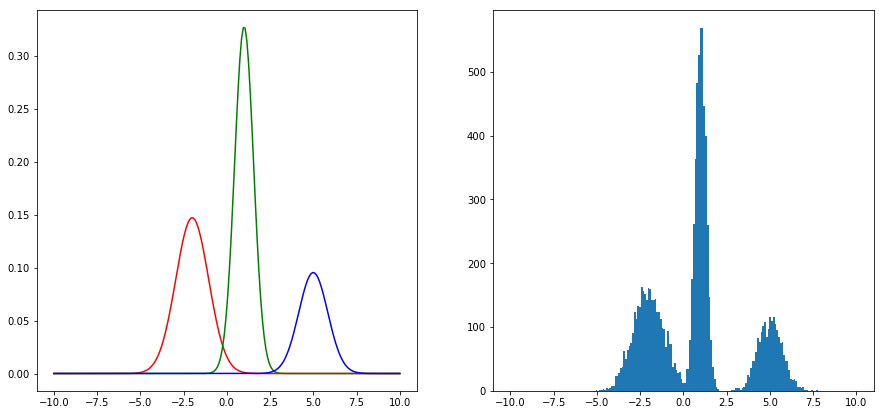

In [29]:
plt.figure(1, figsize=(15,7))
x = np.linspace(-10,10,(10-(-10))/0.1)
plt.subplot(1,2,1)
plt.plot(x,pi_true[0] * multivariate_normal.pdf(x, mu_true[0], sigma_true[0]),'r')
plt.plot(x,pi_true[1] * multivariate_normal.pdf(x, mu_true[1], sigma_true[1]),'g')
plt.plot(x,pi_true[2] * multivariate_normal.pdf(x, mu_true[2], sigma_true[2]),'b')

plt.subplot(1,2,2)
plt.hist(obs, bins=np.linspace(-10,10,(10-(-10))/0.1))
plt.show()

### 결과 해석부 1

왼쪽 그래프는 GMM의 pdf를 나타낸 것이고, 오른쪽 그래프는 Forward Sampling한 X값들을 히스토그램으로 나타낸 것입니다.  
그래프에서 보이듯이 샘플들의 히스토그램은 GMM의 pdf와 상당히 일치합니다.
이처럼 pdf를 모르는 모델에 대해서도 충분히 많은 횟수의 샘플링을 반복한다면 모델의 pdf의 개형을 쉽게 그릴 수 있습니다. 

그러나 Forward Sampling으로 구한 확률값에 대한 신뢰도를 높이기 위해서는 수없이 많은 횟수의 반복을 필요로하며, Bayesian Network의 규모가 커지면 위상적 순서에 따라 sample을 하나씩 생성하는데 많은 시간이 소모된다.  
또한, 초기 확률이나 조건부 확률값이 매우 작은 event에 대한 확률값을 구할때에는 대부분의 sample이 필요 없게되는 문제가 발생한다.

## Rejection Sampling

In [30]:
def displayStackedHistogram(data1, data2, nbins, lowBound, highBound): 
    data = [data1, data2]    
    bins = np.linspace(lowBound, highBound, nbins)
    
    plt.hist(data, bins,  histtype='bar', stacked=True)

### 1) q ~ $0.35*N(-2,0.9)+0.45*N(1,0.3)+0.2*N(5,0.8)$

In [31]:
cnt = -1 # cnt : Accepted sample의 갯수
discarded = 0 # discarded : Rejected sample의 갯수
obs = np.zeros(N) # obs : Accepted sample의 값을 저장
samples = [] # samples : 전체 생성된 Sample의 값을 저장
rejected_samples = [] # rejected_samples : Rejected sample의 값을 저장

M = 20
mu_assumed = np.array([-2,1,5]) # mu_assumed = [mu_q1, mu_q2, mu_q3]
sigma_assumed = np.array([1, 1, 1]) # sigma_assumed = [sigma_q1, sigma_q2, sigma_q3]

while cnt < N-1: # 생성된 Sample 갯수가 N개가 될 때 까지 반복 시행 (-1 ~ N-2) 
    idx = np.random.randint(0,3) # 1,2,3에서 random으로 integer 하나를 선택하고 -1
    sample = np.random.normal(mu_assumed[idx], sigma_assumed[idx]) 
    q = 1/3. * multivariate_normal.pdf(sample, mu_assumed[idx], sigma_assumed[idx]) # q : N(mu_assumed, sigma_assumed)에서 sample이 나올 확률
    p = pi_true[idx] * multivariate_normal.pdf(sample, mu_true[idx], sigma_true[idx])
    u = np.random.random_sample() # Uniform(0,1)에서 샘플 u 생성
    
    if u*M*q < p: # if True -> 생성된 샘플 값을 저장한다
        cnt = cnt + 1
        obs[cnt] = sample
    else: # 생성된 샘플 값을 reject하고 rejected_samples에 기록한다
        discarded = discarded + 1
        rejected_samples.append(sample)
    samples.append(sample)

In [32]:
rejected_samples = np.asarray(rejected_samples)
samples = np.asarray(samples)

C:\Users\Dong-Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Dong-Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dong-Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
C:\Users\Dong-Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


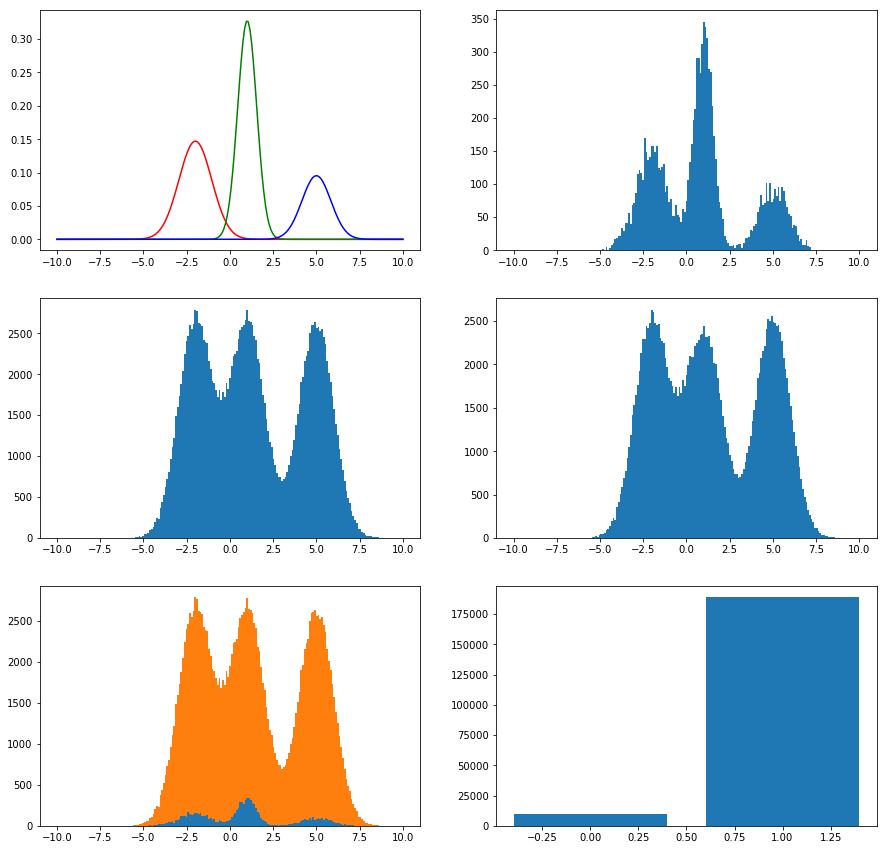

In [33]:
plt.figure(1, figsize=(15,15))

x = np.linspace(-10,10,(10-(-10))/0.1)
plt.subplot(3, 2, 1)
plt.plot(x,pi_true[0] * multivariate_normal.pdf(x, mu_true[0], sigma_true[0]),'r')
plt.plot(x,pi_true[1] * multivariate_normal.pdf(x, mu_true[1], sigma_true[1]),'g')
plt.plot(x,pi_true[2] * multivariate_normal.pdf(x, mu_true[2], sigma_true[2]),'b')

plt.subplot(3, 2, 2)
plt.hist(obs, bins=np.linspace(-10,10,(10-(-10))/0.1))

plt.subplot(3, 2, 3)
plt.hist(samples, bins=np.linspace(-10,10,(10-(-10))/0.1))

plt.subplot(3, 2, 4)
plt.hist(rejected_samples, bins=np.linspace(-10,10,(10-(-10))/0.1))

plt.subplot(3, 2, 5)
displayStackedHistogram(obs, rejected_samples, 200, -10, 10)

plt.subplot(3, 2, 6)
plt.bar(range(len([cnt, discarded])), np.array([cnt, discarded]))
plt.show()

### 2) q ~ $\frac{1}{3}*N(0,1)+\frac{1}{3}*N(0,1)+\frac{1}{3}N(0,1)$

In [34]:
cnt = -1 # cnt : Accepted sample의 갯수
discarded = 0 # discarded : Rejected sample의 갯수
obs = np.zeros(N) # obs : Accepted sample의 값을 저장
samples = [] # samples : 전체 생성된 Sample의 값을 저장
rejected_samples = [] # rejected_samples : Rejected sample의 값을 저장

M = 20
mu_assumed = np.array([0,0,0]) # mu_assumed = [mu_q1, mu_q2, mu_q3]
sigma_assumed = np.array([1,1,1]) # sigma_assumed = [sigma_q1, sigma_q2, sigma_q3]

while cnt < N-1: # 생성된 Sample 갯수가 N개가 될 때 까지 반복 시행 (-1 ~ N-2) 
    idx = np.random.randint(0,3) # 1,2,3에서 random으로 integer 하나를 선택하고 -1
    sample = np.random.normal(mu_assumed[idx], sigma_assumed[idx]) 
    q = 1/3. * multivariate_normal.pdf(sample, mu_assumed[idx], sigma_assumed[idx]) # q : N(mu_assumed, sigma_assumed)에서 sample이 나올 확률
    p = pi_true[idx] * multivariate_normal.pdf(sample, mu_true[idx], sigma_true[idx])
    u = np.random.random_sample() # Uniform(0,1)에서 샘플 u 생성
    
    if u*M*q < p: # if True -> 생성된 샘플 값을 저장한다
        cnt = cnt + 1
        obs[cnt] = sample
    else: # 생성된 샘플 값을 reject하고 rejected_samples에 기록한다
        discarded = discarded + 1
        rejected_samples.append(sample)
    samples.append(sample)

In [35]:
rejected_samples = np.asarray(rejected_samples)
samples = np.asarray(samples)

C:\Users\Dong-Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Dong-Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dong-Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]
C:\Users\Dong-Hyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


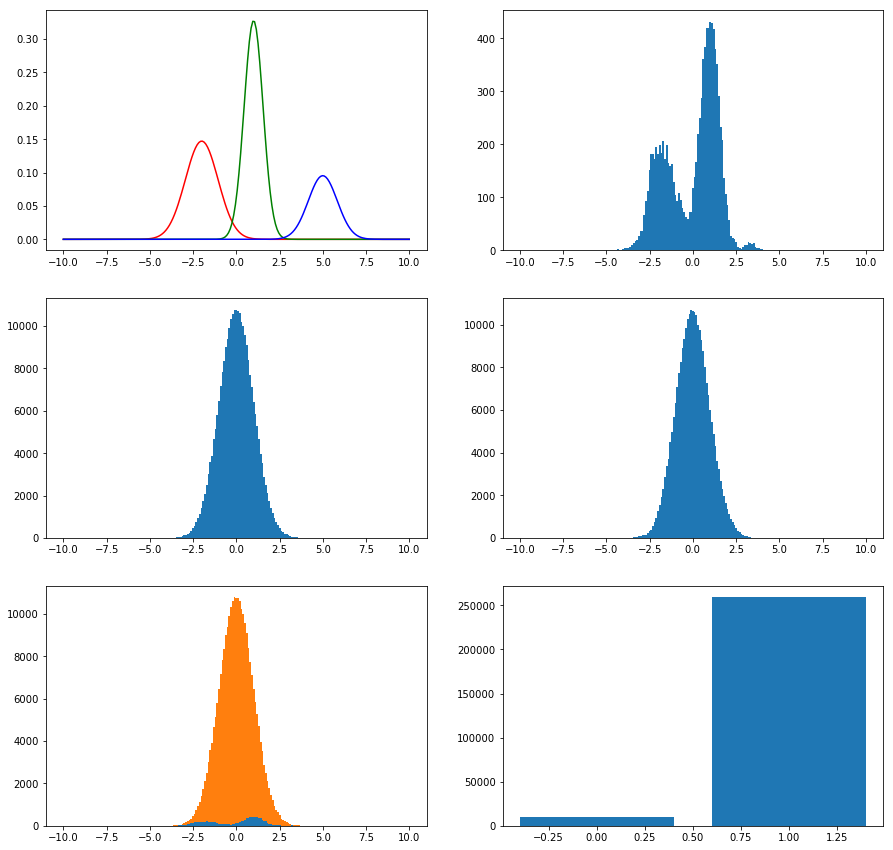

In [36]:
plt.figure(1, figsize=(15,15))

x = np.linspace(-10,10,(10-(-10))/0.1)
plt.subplot(3, 2, 1)
plt.plot(x,pi_true[0] * multivariate_normal.pdf(x, mu_true[0], sigma_true[0]),'r')
plt.plot(x,pi_true[1] * multivariate_normal.pdf(x, mu_true[1], sigma_true[1]),'g')
plt.plot(x,pi_true[2] * multivariate_normal.pdf(x, mu_true[2], sigma_true[2]),'b')

plt.subplot(3, 2, 2)
plt.hist(obs, bins=np.linspace(-10,10,(10-(-10))/0.1))

plt.subplot(3, 2, 3)
plt.hist(samples, bins=np.linspace(-10,10,(10-(-10))/0.1))

plt.subplot(3, 2, 4)
plt.hist(rejected_samples, bins=np.linspace(-10,10,(10-(-10))/0.1))

plt.subplot(3, 2, 5)
displayStackedHistogram(obs, rejected_samples, 200, -10, 10)

plt.subplot(3, 2, 6)
plt.bar(range(len([cnt, discarded])), np.array([cnt, discarded]))
plt.show()

## 결과해석부 2

1) q ~ $0.35*N(-2,0.9)+0.45*N(1,0.3)+0.2*N(5,0.8)$

1번째 그래프는 $0.35*N(-2,0.9)+0.45*N(1,0.3)+0.2*N(5,0.8)$의 pdf를 나타낸 것이며 우측의 2번째 그래프는 Rejection Sampling한 X값들을 히스토그램으로 나타낸 것입니다.  
두 그래프 모두 세 봉우리를 가지고 있으며, 각 봉우리의 x 좌표가 -2,1,5로 일치하므로 두 그래프는 상당히 일치하는 것으로 보입니다.  
결론적으로 Sampling이 유의미한 수준으로 잘 되었다고 할 수 있습니다.

이 결과는 q(x)를 가정할 때 p(x)와 형태가 거의 유사하도록 설정했기 때문에 가능한 것으로 보입니다.   

2) q ~ $\frac{1}{3}*N(0,1)+\frac{1}{3}*N(0,1)+\frac{1}{3}N(0,1)$

1번째 그래프는 $\frac{1}{3}*N(0,1)+\frac{1}{3}*N(0,1)+\frac{1}{3}N(0,1)$의 pdf를 나타낸 것이며 우측의 2번째 그래프는 Rejection Sampling한 X값들을 히스토그램으로 나타낸 것입니다.

첫 번째의 q(x)와 비교했을 경우, 이번 가정에 따른 q(x)는 실제 p(x)와 형태에 있어서 많은 차이가 나타나며 이는 Sampling의 결과에도 영향을 미칩니다.  
실제로 2번째 그래프를 보면 첫 번째와 두 번째 봉우리는 비교적 유사하지만 세 번째 봉우리는 거의 나타나지 않았음을 알 수 있습니다.  
이 결과는 p(x)가 M*q(x)보다 더 크기 때문에 나타나므로 이를 해결하기 위해서는 M을 더욱 키워야합니다. 그러나 M을 키우면 샘플을 기각할 확률 또한 높아지게 됩니다.